In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('Final Data.csv')
df.drop({"Unnamed: 0",'Polarity','Scores','Review','len'},inplace=True,axis=1)
df.head()

,Rating,New_Review,Sentiment
0,4,nice hotel expensive parking got good deal sta...,positive
1,2,ok nothing special charge diamond member hilto...,positive
2,3,nice room experience hotel monaco seattle good...,positive
3,5,unique great stay wonderful time hotel monaco ...,positive
4,5,great stay great stay wenot seahawk game aweso...,positive


In [3]:
df['target'] = df['Sentiment'].replace({'positive':1,'neutral':0,'negative':-1})
df.head()

,Rating,New_Review,Sentiment,target
0,4,nice hotel expensive parking got good deal sta...,positive,1
1,2,ok nothing special charge diamond member hilto...,positive,1
2,3,nice room experience hotel monaco seattle good...,positive,1
3,5,unique great stay wonderful time hotel monaco ...,positive,1
4,5,great stay great stay wenot seahawk game aweso...,positive,1


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=10000, tokenizer = word_tokenize)
X = tfidf.fit_transform(df['New_Review'])
y = df['target']

In [5]:
import pickle
pickle_out=open('vectorizer.pkl','wb')
pickle.dump(tfidf,pickle_out)
pickle_out.close()

#### Splitting dataset

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=123)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(15368, 10000)
(15368,)
(5123, 10000)
(5123,)


#### Multinominal Naive Bayes Classifier

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

classf = MultinomialNB()
classf.fit(X_train, y_train)
pred = classf.predict(X_test)
mul_model_score=round(accuracy_score(y_test, pred)*100,2)
print("Naive Bayes:",mul_model_score)

Naive Bayes: 92.29


#### Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
pred = lr_model.predict(X_test)
log_model_score=round(accuracy_score(y_test, pred)*100,2)
print("Logistic Regression:",log_model_score)

Logistic Regression: 94.51


#### Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier
dt_model=DecisionTreeClassifier()
dt_model.fit(X_train,y_train)
pred = dt_model.predict(X_test)
dec_model_score=round(accuracy_score(y_test, pred)*100,2)
print("Decision Tree:",dec_model_score)

Decision Tree: 90.96


#### Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf_model=RandomForestClassifier()
rf_model.fit(X_train,y_train)
pred = rf_model.predict(X_test)
ran_model_score=round(accuracy_score(y_test, pred)*100,2)
print("Random Forest:",ran_model_score)

Random Forest: 92.84


#### Ada Boost

In [11]:
from sklearn.ensemble import AdaBoostClassifier
ada_model=AdaBoostClassifier()
ada_model.fit(X_train,y_train)
pred = ada_model.predict(X_test)
ada_model_score=round(accuracy_score(y_test, pred)*100,2)
print("AdaBoost:",ada_model_score)

AdaBoost: 93.85


#### Linear SVC

In [12]:
from sklearn.svm import LinearSVC
svc_model = LinearSVC()
svc_model.fit(X_train, y_train)
pred = svc_model.predict(X_test)
svc_model_score=round(accuracy_score(y_test, pred)*100,2)
print("Linear SVC:",svc_model_score)

Linear SVC: 95.37


#### Model Evaluation 

In [13]:
Evaluation = {
    "Models":pd.Series(["Multinominal Naive Bayes","Logistic Regression","Decision Tree","Random Forest","Ada Boost","Linear SVC"]),\
    "Accuracy Score":pd.Series([mul_model_score,log_model_score,dec_model_score,ran_model_score,ada_model_score,svc_model_score])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Accuracy Score'], inplace=True, ignore_index=True,ascending=False)
table_evaluation

,Models,Accuracy Score
0,Linear SVC,95.37
1,Logistic Regression,94.51
2,Ada Boost,93.85
3,Random Forest,92.84
4,Multinominal Naive Bayes,92.29
5,Decision Tree,90.96


#### Observation : Among all the models Linear SVC give better accuracy.i.e we select Linear SVC as Final Model.

#### Final Model - Linear SVC

on Test Data:
Confusion Matrix:
 [[ 210    0  132]
 [  12    0   55]
 [  37    1 4676]]
Accuracy Score: 95.37
              precision    recall  f1-score   support

          -1       0.81      0.61      0.70       342
           0       0.00      0.00      0.00        67
           1       0.96      0.99      0.98      4714

    accuracy                           0.95      5123
   macro avg       0.59      0.54      0.56      5123
weighted avg       0.94      0.95      0.95      5123



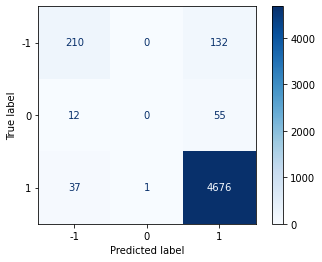

In [14]:
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix
final_model = LinearSVC()
final_model.fit(X_train, y_train)
print("on Test Data:")
pred_test = final_model.predict(X_test)
cm = confusion_matrix(y_test, pred_test)
print("Confusion Matrix:\n",cm)
svc_model_score=round(accuracy_score(y_test, pred_test)*100,2)
print("Accuracy Score:",svc_model_score)
print(classification_report(y_test,pred_test))

plot_confusion_matrix(final_model, X_test, y_test,cmap=plt.cm.Blues)
plt.show()

#### Prediction

In [15]:
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
wordnet=WordNetLemmatizer()
ps = PorterStemmer()
cv = CountVectorizer()
from wordcloud import WordCloud, STOPWORDS
from rake_nltk import Rake

In [16]:
def get_top_n2_words(corpus, n=None):
    vec1 = TfidfVectorizer(ngram_range=(2,2),  #for tri-gram, put ngram_range=(3,3)
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

In [17]:
def clean_text(a):
    print("Number of words in Review:", len(a.split()))
    text=re.sub('[^A-za-z0-9]',' ',a)
    text=text.lower()
    text=text.split(' ')
    text = [wordnet.lemmatize(word) for word in text if word not in (stopwords.words('english'))]
    text = ' '.join(text)
   
    top2_words = get_top_n2_words([text],n=5) 
    df = pd.DataFrame(top2_words)
    df.columns=["Bi-gram", "Freq"]
    print(df)
    
    return text

In [18]:
def expression_check(prediction_input):
    if prediction_input == -1:
        print("Negative")
    elif prediction_input == 1:
        print("Positive")
    else:
        print("Neutral")

In [19]:
def sentiment_predictor(input):
    input = clean_text(input)
    transformed_input = tfidf.transform([input])
    prediction = final_model.predict(transformed_input)
    expression_check(prediction)
    r = Rake(language='english', stopwords=STOPWORDS)
    r.extract_keywords_from_text(input)
    r.get_ranked_phrases()
    print(r.get_ranked_phrases())

In [20]:
negative_review_test= ("This is hotel is the worst one....Staff are terrible....front desk guys were worst and indifferent..")
sentiment_predictor(negative_review_test)

Number of words in Review: 15
          Bi-gram      Freq
0     hotel worst  0.333333
1       worst one  0.333333
2       one staff  0.333333
3  staff terrible  0.333333
4  terrible front  0.333333
Negative
['hotel worst one staff terrible front desk guy worst indifferent']


In [21]:
positive_review_test = ("Our room was enormous, with a nice view of the river. It was 105 degrees (Fahrenheit) when we stayed but every thing was kept cool")
sentiment_predictor(positive_review_test)

Number of words in Review: 25
         Bi-gram      Freq
0  room enormous  0.288675
1  enormous nice  0.288675
2      nice view  0.288675
3     view river  0.288675
4      river 105  0.288675
Positive
['room enormous nice view river 105 degree fahrenheit stayed every thing kept cool']


In [22]:
import pickle
# Saving the pickle file
pickle.dump(final_model, open('Hotel_Rating_SVC.pkl','wb'))